### Import Packages

In [33]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Define Functions

In [37]:
PRODUCT_NAMES = ['Product_A', 'Product_B', 'Product_C', 'Product_D', 'Product_E']
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']


def generate_ascending_dates(start_date, num_rows):
    dates = [start_date + timedelta(days=i) for i in range(num_rows)]
    return dates


def create_dummy_dataset(num_rows, date_start):
    date_start = datetime.strptime(date_start, '%Y-%m-%d')
  
    dates = generate_ascending_dates(date_start, num_rows)
    
  
    months = [date.strftime('%B') for date in dates]  # Month names
    years = [date.year for date in dates]             # Year values
    

    data = {
        'Date': dates, 
        'Product_Name': [random.choice(PRODUCT_NAMES) for _ in range(num_rows)],  # Product names
        'Month': months,                                                         # Month
        'Year': years,                                                           # Year
        'Quantity': np.random.randint(1, 100, size=num_rows),                    # Quantities
        'Unit_Price': np.random.uniform(10, 100, size=num_rows)                  # Random unit price for each product
    }
    
 
    data['Sales_Revenue'] = data['Quantity'] * data['Unit_Price']
    df = pd.DataFrame(data)
    df = df.drop('Unit_Price', axis=1)
    print(df)
    
    return df



df = create_dummy_dataset(num_rows=100, date_start='2023-01-01')



         Date Product_Name    Month  Year  Quantity  Sales_Revenue
0  2023-01-01    Product_E  January  2023        28     615.659130
1  2023-01-02    Product_D  January  2023        54    3665.712739
2  2023-01-03    Product_C  January  2023        39     551.328431
3  2023-01-04    Product_C  January  2023        76    2559.816053
4  2023-01-05    Product_C  January  2023        65    2320.731004
..        ...          ...      ...   ...       ...            ...
95 2023-04-06    Product_A    April  2023        36     797.276043
96 2023-04-07    Product_B    April  2023        44    2093.996420
97 2023-04-08    Product_A    April  2023         1      66.506854
98 2023-04-09    Product_A    April  2023        51     797.323726
99 2023-04-10    Product_D    April  2023        99    4500.483452

[100 rows x 6 columns]


In [30]:
def create_lagged_features(df, lag_days=7):
    for i in range(1, lag_days + 1):
        df[f'Sales_Revenue_Lag_{i}'] = df['Sales_Revenue'].shift(i)
    df = df.dropna().reset_index(drop=True)
    
    print(df)
    return df
df_lagged = create_lagged_features(df_processed, lag_days=7)

    Product_Name  Month  Year  Quantity  Sales_Revenue  Sales_Revenue_Lag_1  \
0              1      2  2023        25    1353.723467          9607.310300   
1              1      2  2023        42     599.419821          1353.723467   
2              1      2  2023        88    1112.156339           599.419821   
3              2      2  2023        89    1745.946696          1112.156339   
4              3      2  2023        89    3026.111113          1745.946696   
..           ...    ...   ...       ...            ...                  ...   
88             3      0  2023        12     576.590389           929.992434   
89             3      0  2023        87    1427.303449           576.590389   
90             1      0  2023        90    5791.886260          1427.303449   
91             2      0  2023        26    2343.745465          5791.886260   
92             3      0  2023        70    6830.334153          2343.745465   

    Sales_Revenue_Lag_2  Sales_Revenue_Lag_3  Sales

### Preprocessing

In [38]:
def preprocess_data(df):

    label_encoders = {}
    le_product = LabelEncoder()
    df['Product_Name'] = le_product.fit_transform(df['Product_Name'])
    label_encoders['Product_Name'] = le_product
    month_mapping = {month: i + 1 for i, month in enumerate(MONTHS)}
    df['Month'] = df['Month'].map(month_mapping)
    df = df.drop('Date', axis=1)
    print(df)
    
    return df, label_encoders

df_processed, label_encoders = preprocess_data(df)

    Product_Name  Month  Year  Quantity  Sales_Revenue
0              4      1  2023        28     615.659130
1              3      1  2023        54    3665.712739
2              2      1  2023        39     551.328431
3              2      1  2023        76    2559.816053
4              2      1  2023        65    2320.731004
..           ...    ...   ...       ...            ...
95             0      4  2023        36     797.276043
96             1      4  2023        44    2093.996420
97             0      4  2023         1      66.506854
98             0      4  2023        51     797.323726
99             3      4  2023        99    4500.483452

[100 rows x 5 columns]


### Lagged Features

In [39]:

def create_lagged_features(df, lag_days=7):

    df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
    for i in range(1, lag_days + 1):
        df[f'Sales_Revenue_Lag_{i}'] = df['Sales_Revenue'].shift(i)

    df = df.dropna().reset_index(drop=True)
    print(df)
    
    return df


df_lagged = create_lagged_features(df_processed, lag_days=7)


    Product_Name  Month  Year  Quantity  Sales_Revenue  Sales_Revenue_Lag_1  \
0              3      1  2023        47     781.412844          4137.829308   
1              3      1  2023        89    5792.797849           781.412844   
2              3      1  2023        43    2029.778093          5792.797849   
3              4      1  2023        41    2660.971782          2029.778093   
4              3      1  2023        87    1512.053988          2660.971782   
..           ...    ...   ...       ...            ...                  ...   
88             0      4  2023        36     797.276043          2726.620381   
89             1      4  2023        44    2093.996420           797.276043   
90             0      4  2023         1      66.506854          2093.996420   
91             0      4  2023        51     797.323726            66.506854   
92             3      4  2023        99    4500.483452           797.323726   

    Sales_Revenue_Lag_2  Sales_Revenue_Lag_3  Sales

### Training

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 65, number of used features: 10
[LightGBM] [Info] Start training from score 2751.129244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

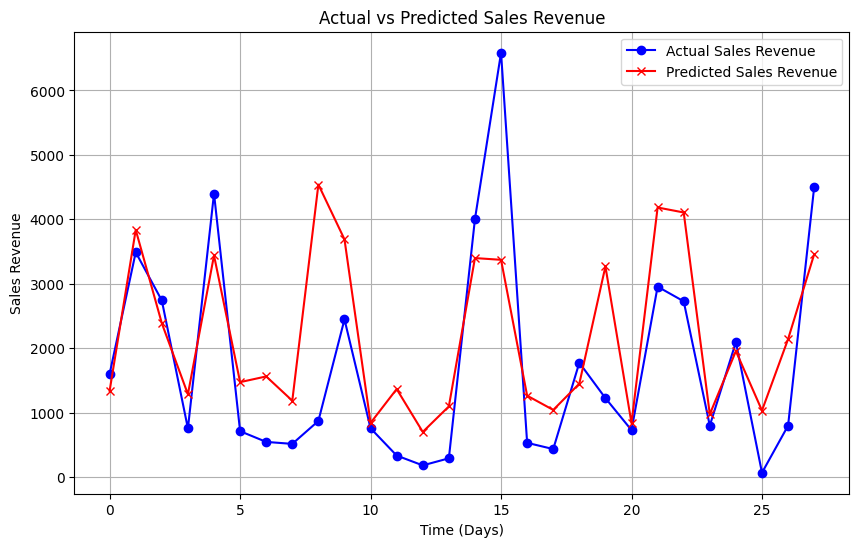

Predicted Sales Revenue for the next day: 3456.6157


In [41]:
def train_and_evaluate_model(df_processed):
    X = df_processed.drop(['Sales_Revenue'], axis=1) 
    y = df_processed['Sales_Revenue']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)


    y_pred = lgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.4f}')


    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Sales Revenue', marker='o', color='b')
    plt.plot(y_pred, label='Predicted Sales Revenue', marker='x', color='r')
    plt.title('Actual vs Predicted Sales Revenue')
    plt.xlabel('Time (Days)')
    plt.ylabel('Sales Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Predict the next day's sales revenue (for the day after the last date in the test set)
    last_known_data = X_test.iloc[-1:].copy()  # Get the last 7 days of data
    next_day_pred = lgb_model.predict(last_known_data)
    print(f'Predicted Sales Revenue for the next day: {next_day_pred[0]:.4f}')


train_and_evaluate_model(df_lagged)

